We have a lot of independent scripts here that in some time of the development was usefull.

In sequence:

- create overlaped video
- create overlaped images from a given list
- Organize dataset: organize from sideseeing format to DHF1K format
- reads a folder containing enumerated images and creates a video from these images.
- iterate over videos and use ffmpeg to extract frames

install:
`pip install opencv-python tqdm`

In [ ]:
"""
This code creates a video by overlaying masks onto corresponding images.
It reads image-mask pairs from specified fol onto corresponding images.
It reads image-mask pairs from specified folders, applies a semi-transparent heatmap, and combines them into a video.
The output video is saved with a given frame rate and resolution and at a given path.
"""

import cv2
import os
import numpy as np
from tqdm import tqdm

# Paths to images and masks
image_folder = "/home/suayder/Desktop/method2/images/" 
# mask_folder = "/scratch/suayder/urbanaccess_dhf1_vcentered/val/0004/maps/" # ground truth
mask_folder = "/home/suayder/Desktop/method2/maps/"
output_video = "/home/suayder/Desktop/method2.mp4"

frames_to_save = ['00100.jpg', '00500.jpg', '01000.jpg', '01200.jpg'] # a fixed list of frames to save

# Video parameters
frame_rate = 30  # Frames per second
overlay_color = (0, 255, 0)  # Green overlay for mask (can be changed)
alpha = 0.3  # Transparency of the mask overlay

# Get sorted list of images and masks (assumes same filenames)
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

image_files = [im for im in image_files if im in mask_files] # REMOVER

# Ensure image and mask count match
if len(image_files) != len(mask_files):
    raise ValueError("Number of images and masks do not match! {} vs {}".format(len(image_files), len(mask_files)))

# Read first image to get frame size
sample_image = cv2.imread(os.path.join(image_folder, image_files[0]))
height, width, _ = sample_image.shape

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video, fourcc, frame_rate, (width, height))

# Process each image and corresponding mask
pbar = tqdm(zip(image_files, mask_files), total=len(image_files), desc="Processing images")
for img_name, mask_name in pbar:
    pbar.set_description("Processing %s" % img_name)
    img_path = os.path.join(image_folder, img_name)
    mask_path = os.path.join(mask_folder, mask_name)

    # Read image and mask
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    if image is None or mask is None:
        print(f"Skipping {img_name} due to loading error.")
        continue

    # Normalize mask to 0-255 range if needed
    mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX)

    # Apply a heatmap color map
    heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    overlayed_image = cv2.addWeighted(image, 1, heatmap, alpha, 0)
    if img_name in frames_to_save:
        cv2.imwrite(img_name.replace('.png', '.jpg'), overlayed_image)
    # Write frame to video
    video_writer.write(overlayed_image)


# Release video writer
video_writer.release()
print(f"Video saved as {output_video}")


In [ ]:
"""
This code generate ovelayed images from its corresponding ma masks onto corresponding images.
"""
import cv2
import os
import numpy as np
from tqdm import tqdm

# Paths to images and masks
image_folder = "/data/JBCS_paper/data/val/0002/images/" 
mask_folder = "/data/JBCS_paper/inferences/method_2/tmfi-centered/"


frames_to_save = ['00025.jpg','00260.jpg', '00741.jpg', '01933.jpg'] 


alpha = 0.3  # Transparency of the mask overlay

# Get sorted list of images and masks (assumes same filenames)
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

image_files = [im for im in image_files if im in mask_files]

# Ensure image and mask count match
if len(image_files) != len(mask_files):
    raise ValueError("Number of images and masks do not match! {} vs {}".format(len(image_files), len(mask_files)))

# Read first image to get frame size
sample_image = cv2.imread(os.path.join(image_folder, image_files[0]))
height, width, _ = sample_image.shape

# Process each image and corresponding mask

for img_name, mask_name in zip(image_files, mask_files):
    if img_name not in frames_to_save:
        continue

    img_path = os.path.join(image_folder, img_name)
    mask_path = os.path.join(mask_folder, mask_name)

    # Read image and mask
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    if image is None or mask is None:
        print(f"Skipping {img_name} due to loading error.")
        continue

    # Normalize mask to 0-255 range if needed
    mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX)

    # Apply a heatmap color map
    heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    overlayed_image = cv2.addWeighted(image, 1, heatmap, alpha, 0)
    cv2.imwrite(img_name.replace('.png', '.jpg'), overlayed_image)

print(f"done")

In [ ]:
"""
Organize dataset: organize from sideseeing format to DHF1K format
this script will make a copy of images/ fixations/ and maps/ to a folder, you have the choice to say if is train or test data.

In summary, will transform from this:

src_dir/
  ├── data/
  │   ├── Area1/
  │   │   ├── Block1/
  │   │   │   ├── fixations/
  │   │   │   ├── images/
  │   │   │   ├── maps/

to this:

processed_dataset/
  ├── train/
  │   ├── Area1#Block1/
  │   │   ├── fixations/
  │   │   ├── images/
  │   │   ├── maps/

you can apply rename_name2numbers to have a dataset like this

processed_dataset/
  ├── train/
  │   ├── 0000/
  │   │   ├── fixations/
  │   │   ├── images/
  │   │   ├── maps/
  │   ├── 0001/

"""

import os
import concurrent.futures
import shutil
from pathlib import Path

def reorganize_dataset(src_dir, dest_dir, split='train'):
    """
    Reorganizes the dataset into the desired format.

    - split (str): Either 'train' or 'val' to specify the split.
    """

    src_path = Path(src_dir)
    dest_path = Path(dest_dir) / split
    
    if not src_path.exists():
        print(f"Source directory '{src_dir}' does not exist.")
        return

    # Create destination directory if it doesn't exist
    dest_path.mkdir(parents=True, exist_ok=True)

    # Iterate through areas and blocks in the dataset
    for area_dir in src_path.glob("data/*"):
        if area_dir.is_dir():
            for block_dir in area_dir.glob("*"):
                if block_dir.is_dir():
                    # Construct the new folder name
                    new_folder_name = f"{area_dir.name}#{block_dir.name}"
                    new_folder_path = dest_path / new_folder_name
                    new_folder_path.mkdir(parents=True, exist_ok=True)

                    # Move required subdirectories/files
                    for subfolder in ['fixations', 'images', 'maps']:
                        # subfolder = subfolder+'_centered' if subfolder!='images' else subfolder
                        src_subfolder = block_dir / subfolder
                        if src_subfolder.exists():
                            dest_subfolder = new_folder_path / subfolder
                            dest_subfolder.mkdir(parents=True, exist_ok=True)

                            def copy_file(file):
                                if file.is_file():
                                    shutil.copy(file, dest_subfolder)

                            with concurrent.futures.ThreadPoolExecutor() as executor:
                                executor.map(copy_file, src_subfolder.iterdir())
                            # for file in src_subfolder.iterdir():
                            #     if file.is_file():
                            #         shutil.copy(file, dest_subfolder)

    print(f"Dataset reorganized under '{dest_path}'.")

def rename_name2numbers(path, split="train"):

    path = Path(path) / split
    names = sorted(os.listdir(path))

    for i, name in enumerate(names):
        (path / name).rename(path / str(i).zfill(4))

    print('rename_name2numbers done')

# usage
source_directory = "/run/media/suayder/data/side_seeing/urbanaccess/"
destination_directory = "/run/media/suayder/data/JBCS_paper/data"
reorganize_dataset(source_directory, destination_directory, split='val')
rename_name2numbers(destination_directory, split='val')

In [ ]:
"""
This script reads a folder containing enumerated images, sorts the images, and creates a video from these images.

Variables:
    image_folder (str): Path to the folder containing images.
    output_video (str): Name of the output video file.
    frame_rate (int): Frames per second for the output video.
"""
import cv2
import os
from tqdm import tqdm

# image_folder = "/data/JBCS_paper/data/crop/humanb_80/0006/"
image_folder = "/home/suayder/Desktop/method2/maps/"
output_video = "/home/suayder/Desktop/method2_maps.mp4"
frame_rate = 30  # Frames per second

image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))], key=lambda x: int(x.split('.')[0]))

if not image_files:
    raise ValueError("No images found in the specified folder.")

sample_image = cv2.imread(os.path.join(image_folder, image_files[0]))
height, width, _ = sample_image.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video, fourcc, frame_rate, (width, height))

# Process each image and write to video
for img_name in tqdm(image_files):
    img_path = os.path.join(image_folder, img_name)
    image = cv2.imread(img_path)
    if image is None:
        print(f"Skipping {img_name} due to loading error.")
        continue
    video_writer.write(image)

# Release video writer
video_writer.release()
print(f"Video saved as {output_video}")

In [ ]:
import os
import glob
import subprocess

def video2frames(input_path, output_path, frame_rate=30):
    
    os.makedirs(output_path, exist_ok=True)

    ffmpeg_cmd = [
        "ffmpeg",
        "-i", input_path,
        "-vf", f"fps={frame_rate}",
        os.path.join(output_path, "%05d.jpg")
    ]
    try:
        subprocess.run(ffmpeg_cmd, check=True)
        print(f"Frames extracted successfully from {input_path} to {output_path}.")
    except subprocess.CalledProcessError as e:
        print(f"Error running FFmpeg: {e}")

input_folder = "/run/media/suayder/data/JBCS_paper/ds1/videos"
output_folder = "/run/media/suayder/data/JBCS_paper/ds1/images"
video_files = glob.glob(os.path.join(input_folder, "**/*.mp4"), recursive=True)

for vfile in video_files:
    video_name = os.path.basename(os.path.dirname(vfile))
    output_path = os.path.join(output_folder, video_name)
    video2frames(vfile, output_path)
    print(f'done for {video_name}')

In [ ]:
import cv2

def process_and_stack_images(image_path1, image_path2, output_path):
    # Read the images
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)

    if image1 is None or image2 is None:
        raise ValueError("One or both image paths are invalid or the images could not be loaded.")

    # Resize images to half their original size
    image1_resized = cv2.resize(image1, (image1.shape[1] // 2, image1.shape[0] // 2))
    image2_resized = cv2.resize(image2, (image2.shape[1] // 2, image2.shape[0] // 2))

    # Stack images vertically
    stacked_image = cv2.vconcat([image1_resized, image2_resized])

    # Save the final image
    cv2.imwrite(output_path, stacked_image)
    print(f"Final image saved at {output_path}")

# Example usage
image_path1 = "tac_original_overlay.jpg"
image_path2 = "tac_crop.jpg"
output_path = "htac_img.jpg"
process_and_stack_images(image_path1, image_path2, output_path)

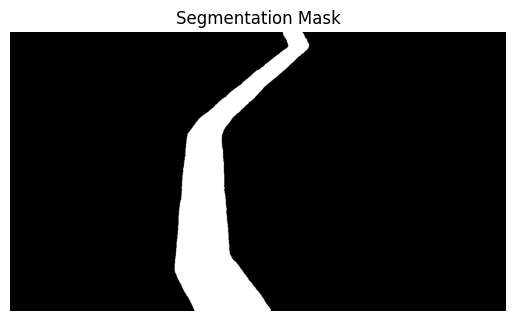

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Display the .npy file as an image

def display_npy_file(file_path):
    # Load the .npy file
    data = np.load(file_path)[0]
    # use numpy to reverse
    # data = np.transpose(data, (2, 0, 1))
    # Display the contents
    plt.imshow(data, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')
    plt.show()

# Example usage
npy_file_path = ""  # Replace with your .npy file path
display_npy_file(npy_file_path)
